In [1]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import searchs
import utils
import models
%matplotlib inline

Using TensorFlow backend.
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
tee_ny = image.load_img("tee_ny.jpg")
tee_ny_array = image.img_to_array(tee_ny)

In [3]:
#plt.figure(figsize = (15,15))
#plt.imshow(tee_ny);

Definitions

In [4]:
model_width = 224
half_model_width = int(224 * .5)
est_location = 200
half_est_location = int(est_location * .5)

In [5]:
target_pixels = raw_input('Enter target pixels seperated by a comma:')

Enter target pixels seperated by a comma:300, 300


In [6]:
#actual locations, random locations, suggested pix locations are visual points of interest
pix_x, pix_y = int(target_pixels.split(',')[0]), int(target_pixels.split(',')[1])
rand_pix_x = np.random.randint(pix_x - half_est_location, pix_x + half_est_location)
rand_pix_y = np.random.randint(pix_y - half_est_location, pix_y + half_est_location)
x_start, x_finish, y_start, y_finish = utils.start_lines(pix_x, pix_y)
rand_x_start, rand_x_fin, rand_y_start, rand_y_fin = utils.start_lines(rand_pix_x, rand_pix_y)

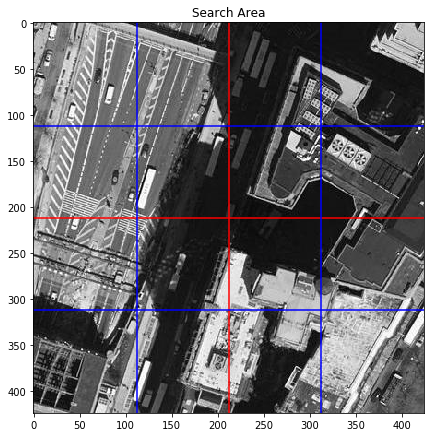

In [7]:
search_img_array = tee_ny_array[rand_y_start : rand_y_fin, rand_x_start: rand_x_fin, :]
search_img = image.array_to_img(search_img_array)
plt.figure(figsize = (7,10))
plt.title('Search Area')
plt.axvline(x = 212, color = 'red')
plt.axhline(y = 212, color = 'red')
plt.axvline(x = 212 - 100, color = 'blue')
plt.axhline(y = 212 + 100, color = 'blue')
plt.axvline(x = 212 + 100, color = 'blue')
plt.axhline(y = 212 - 100, color = 'blue')
#plt.axis('off')
plt.imshow(search_img);

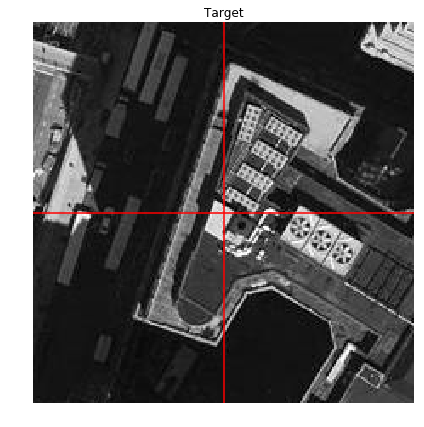

In [8]:
#Target Image and target to predict
x_img_array = utils.get_img_slice(tee_ny_array, pix_x - half_model_width, pix_y - half_model_width, model_width)
x_img = image.array_to_img(x_img_array)
goal_pred = models.get_pred(x_img)
plt.figure(figsize = (7,7))
plt.title('Target')
plt.axvline(x= model_width * .5, color= 'red')
plt.axhline(y= model_width * .5, color= 'red')
plt.axis('off')
plt.imshow(x_img);

In [9]:
x, y = searchs.search(tee_ny_array, goal_pred, 20, rand_x_start, rand_y_start)

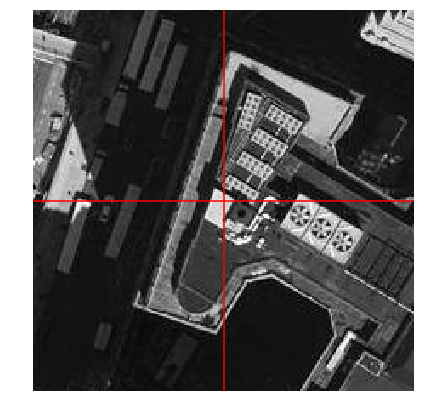

In [13]:
z_img = utils.get_img_slice(tee_ny_array, x, y, model_width)
z_img = image.array_to_img(z_img)
plt.figure(figsize = (7,7))
plt.axvline(x = model_width * .5, color = 'red')
plt.axhline(y = model_width * .5, color = 'red')
plt.axis('off')
plt.imshow(z_img);

In [16]:
print('Predicted:', x + 112, y + 112)
print('Actual:', pix_x, pix_y)

('Predicted:', 300, 300)
('Actual:', 300, 300)
